In [263]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.io import fits
from matplotlib import rcParams
from astropy.wcs import WCS 
from pathlib import Path
from reproject import reproject_interp
import sep
#import fitsio
import photutils
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
rcParams['figure.figsize'] = [12., 12.]
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
import astropy.units as u

In [264]:


#https://docs.astropy.org/en/stable/io/fits/index.html
# https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)

from astropy.io import fits
from astropy.wcs import WCS
from pathlib import Path

directory = Path(r"C:\Users\FN-2187\StarClusters\Nickel_fits_April13_2023")

fits_files = [f for f in directory.iterdir() if f.suffix.lower() == '.fits']
image_data = []
image_headers = []
records = []

for f in fits_files:
    with fits.open(f) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        wcs = WCS(header)
        image_data.append(data)
        image_headers.append(header)
        records.append((f, data, header, wcs))


In [265]:
#https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory
#https://www.w3schools.com/python/ref_string_startswith.asp

bias = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]

domeflatB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]

domeflatV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]

domeflatR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]


In [266]:
rawB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170  
]

In [267]:
#data type dictates where the party goes
print(type(rawB))

<class 'list'>


In [268]:
master_bias=np.median(np.stack(bias),axis=0)

def domecal(filt, bias):
    clean = [flat - bias for flat in filt] 
    master_dome= np.mean(clean, axis=0)
    return master_dome/np.mean(master_dome)

def scical(sci, flat):
    cleaned_images = []
    for image in sci:
        # Subtract bias
        corrected = image - master_bias

        # Divide by normalized flat
        cleaned = corrected / flat

        cleaned_images.append(cleaned)
    
    return cleaned_images

In [269]:
normdomB=domecal(domeflatB,master_bias)
normdomV=domecal(domeflatV,master_bias)
normdomR=domecal(domeflatR,master_bias)

In [270]:
cleaned_sci_imagesB = scical(rawB, normdomB)
cleaned_sci_imagesV = scical(rawV, normdomV)
cleaned_sci_imagesR = scical(rawR, normdomR)

C:\Users\FN-2187\AppData\Local\Temp\ipykernel_7512\2972619361.py:15: RuntimeWarning: divide by zero encountered in divide
  cleaned = corrected / flat
C:\Users\FN-2187\AppData\Local\Temp\ipykernel_7512\2972619361.py:15: RuntimeWarning: invalid value encountered in divide
  cleaned = corrected / flat


In [271]:
 # Clean science frames with only bias correction
# def scical_bias_only(sci, master_bias):
#     cleaned_images = []
#     for image in sci:
#         corrected = (image - master_bias).astype(np.float32)
#         cleaned_images.append(corrected)
#     return cleaned_images



In [272]:
# cleaned_sci_imagesB = bias_only_scical(rawB, normdomB)
# cleaned_sci_imagesV = bias_only_scical(rawV, normdomV)
# cleaned_sci_imagesR = bias_only_scical(rawR, normdomR)

# Key the data

In [273]:
science_images = {
    'B': cleaned_sci_imagesB,
    'V': cleaned_sci_imagesV,
    'R': cleaned_sci_imagesR
}

In [274]:
bias_headers = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]
domeflatB_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]
domeflatV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]
domeflatR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]
rawB_header = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170
]

In [275]:
calibB = [data for f, data in zip(fits_files, image_data) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV = [data for f, data in zip(fits_files, image_data) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR = [data for f, data in zip(fits_files, image_data) if 136 <= int(f.stem.split('d')[-1]) <= 140]

calibB_headers = [header for f, header in zip(fits_files, image_headers) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV_headers = [header for f, header in zip(fits_files, image_headers) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR_headers = [header for f, header in zip(fits_files, image_headers) if 136 <= int(f.stem.split('d')[-1]) <= 140]

stacked_calibB = np.median(np.stack(calibB), axis=0)
stacked_calibV = np.median(np.stack(calibV), axis=0)
stacked_calibR = np.median(np.stack(calibR), axis=0)


In [276]:
print(image_headers[0])

SIMPLE  =                    T / NORMAL FITS IMAGE                              BITPIX  =                   16 / DATA PRECISION                                 NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     NAXIS1  =                 1056 / NUMBER OF COLUMNS                              NAXIS2  =                 1024 / NUMBER OF ROWS                                 CRVAL1U =                 2048 / COLUMN ORIGIN                                  CRVAL2U =                 2048 / ROW ORIGIN                                     CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           OBSNUM  =                  100 / OBSERVATION NUMBER                             IDNUM   =                    2 / IMAGE ID                                       UGEOM   =                    0 / UCAM READOUT GEOMETRY                          DGEOM   =                    0 / DESCRAM

In [277]:
ref_wcs = WCS(rawB_header[0]) # or rawB_header[0]

def align_stack(cleaned_images, headers):
    aligned = []
    for img, hdr in zip(cleaned_images, headers):
        array, _ = reproject_interp((img, WCS(hdr)), ref_wcs)
        aligned.append(array)
    return np.median(np.stack(aligned), axis=0)

stacked_B = align_stack(cleaned_sci_imagesB, rawB_header)
stacked_V = align_stack(cleaned_sci_imagesV, rawV_header)
stacked_R = align_stack(cleaned_sci_imagesR, rawR_header)



In [278]:
from photutils.aperture import CircularAperture, EllipticalAperture, aperture_photometry

def photometry(data, thresh=1.0, minarea=10, use_elliptical=True, flux_percentile_cut=20):
    import numpy as np
    import sep
    from photutils.aperture import CircularAperture, EllipticalAperture, ApertureStats
    from astropy.table import Table

    # Ensure proper dtype and byte order
    data = np.nan_to_num(data.astype(np.float32))
    if data.dtype.byteorder not in ('=', '|'):
        data = data.astype(data.dtype.newbyteorder('='))

    # Background subtraction
    bkg = sep.Background(data)
    data_sub = data - bkg.back()

    # Source extraction
    objects = sep.extract(data_sub, thresh=thresh, minarea=minarea)
    if len(objects) == 0:
        raise ValueError("No sources found in image.")

    # Position arrays
    x = objects['x'].astype(float)
    y = objects['y'].astype(float)
    positions = np.column_stack((x, y))

    phot_table = Table()
    phot_table['xcenter'] = x
    phot_table['ycenter'] = y

    if use_elliptical:
        a = objects['a'].astype(float) * 2.0
        b = objects['b'].astype(float) * 2.0
        theta = objects['theta'].astype(float)

        apertures = [EllipticalAperture((x[i], y[i]), a[i], b[i], theta[i]) for i in range(len(x))]
        stats = [ApertureStats(data_sub, ap) for ap in apertures]
        fluxes = [s.sum for s in stats]
        errors = [s.sum_err for s in stats]

        phot_table['aperture_sum'] = fluxes
        phot_table['flux_err'] = errors

        # Optional: Filter out faintest sources
        if flux_percentile_cut is not None:
            threshold = np.percentile(fluxes, flux_percentile_cut)
            mask = np.array(fluxes) > threshold
            phot_table = phot_table[mask]

    else:
        apertures = CircularAperture(positions, r=3.0)
        phot_table = aperture_photometry(data_sub, apertures)
        phot_table['xcenter'] = x
        phot_table['ycenter'] = y

    return phot_table, objects



In [279]:
phot_tableB, objectsB = photometry(stacked_B, use_elliptical=True)
phot_tableV, objectsV = photometry(stacked_V, use_elliptical=True)
phot_tableR, objectsR = photometry(stacked_R, use_elliptical=True)


In [280]:
print(len(phot_tableB))


5415


In [281]:
from scipy.spatial import cKDTree

# Extract coordinates from photometry tables
coords_B = np.column_stack((phot_tableB['xcenter'], phot_tableB['ycenter']))
coords_V = np.column_stack((phot_tableV['xcenter'], phot_tableV['ycenter']))
coords_R = np.column_stack((phot_tableR['xcenter'], phot_tableR['ycenter']))

# Build KD-trees
tree_V = cKDTree(coords_V)
tree_R = cKDTree(coords_R)

# Match B to V and B to R
max_sep = 3.0  # pixel distance tolerance for matching

dist_BV, idx_BV = tree_V.query(coords_B, distance_upper_bound=max_sep)
dist_BR, idx_BR = tree_R.query(coords_B, distance_upper_bound=max_sep)

# Only keep good matches (where distance is below threshold)
valid_BV = dist_BV < max_sep
valid_BR = dist_BR < max_sep
valid_all = valid_BV & valid_BR

# Final matched indices
idx_B = np.where(valid_all)[0]
idx_V = idx_BV[valid_all]
idx_R = idx_BR[valid_all]


In [282]:
matched_B = phot_tableB[idx_B]
matched_V = phot_tableV[idx_V]
matched_R = phot_tableR[idx_R]

combined_catalog = pd.DataFrame({
    'x': matched_B['xcenter'],
    'y': matched_B['ycenter'],
    'flux_B': matched_B['aperture_sum'],
    'flux_V': matched_V['aperture_sum'],
    'flux_R': matched_R['aperture_sum']
})


In [283]:
# Exposure times (in seconds)
exp_B = 120
exp_V = 120
exp_R = 60

# Convert flux to instrumental magnitudes
mag_B = -2.5 * np.log10(combined_catalog['flux_B']) + 2.5 * np.log10(exp_B)
mag_V = -2.5 * np.log10(combined_catalog['flux_V']) + 2.5 * np.log10(exp_V)
mag_R = -2.5 * np.log10(combined_catalog['flux_R']) + 2.5 * np.log10(exp_R)


In [284]:
combined_catalog['mag_B'] = mag_B
combined_catalog['mag_V'] = mag_V
combined_catalog['mag_R'] = mag_R
combined_catalog['B-V'] = mag_B - mag_V
combined_catalog['V-R'] = mag_V - mag_R


In [285]:
airmasses_B = [hdr.get('AIRMASS') for hdr in rawB_header]
airmasses_V = [hdr.get('AIRMASS') for hdr in rawV_header]
airmasses_R = [hdr.get('AIRMASS') for hdr in rawR_header]

X_B = np.mean([hdr.get('AIRMASS') for hdr in rawB_header])
X_V = np.mean([hdr.get('AIRMASS') for hdr in rawV_header])
X_R = np.mean([hdr.get('AIRMASS') for hdr in rawR_header])




In [287]:
valid_flux_mask = (
    (combined_catalog['flux_B'] > 0) &
    (combined_catalog['flux_V'] > 0) &
    (combined_catalog['flux_R'] > 0)
)
clean_catalog = combined_catalog[valid_flux_mask]


In [289]:
k_B, k_V, k_R = 0.25, 0.15, 0.10  # from Lick table

m_atm_ext_B = k_B * X_B
m_atm_ext_V = k_V * X_V
m_atm_ext_R = k_R * X_R


A_V = 0.20  # from Dust_map.py
A_B = 1.32 * A_V
A_R = 0.81 * A_V


In [ ]:
mag_cat_B = 13.056
mag_cat_V = 13.327
mag_cat_R = 13.456


In [290]:
flux_B = clean_catalog['flux_B']
flux_V = clean_catalog['flux_V']
flux_R = clean_catalog['flux_R']

mag_B_corr = -2.5 * np.log10(flux_B) - m_atm_ext_B - A_B
mag_V_corr = -2.5 * np.log10(flux_V) - m_atm_ext_V - A_V
mag_R_corr = -2.5 * np.log10(flux_R) - m_atm_ext_R - A_R


In [291]:
color_BV = mag_B_corr - mag_V_corr
color_VR = mag_V_corr - mag_R_corr


In [292]:
clean_catalog['mag_B_corr'] = mag_B_corr
clean_catalog['mag_V_corr'] = mag_V_corr
clean_catalog['mag_R_corr'] = mag_R_corr
clean_catalog['B-V'] = color_BV
clean_catalog['V-R'] = color_VR


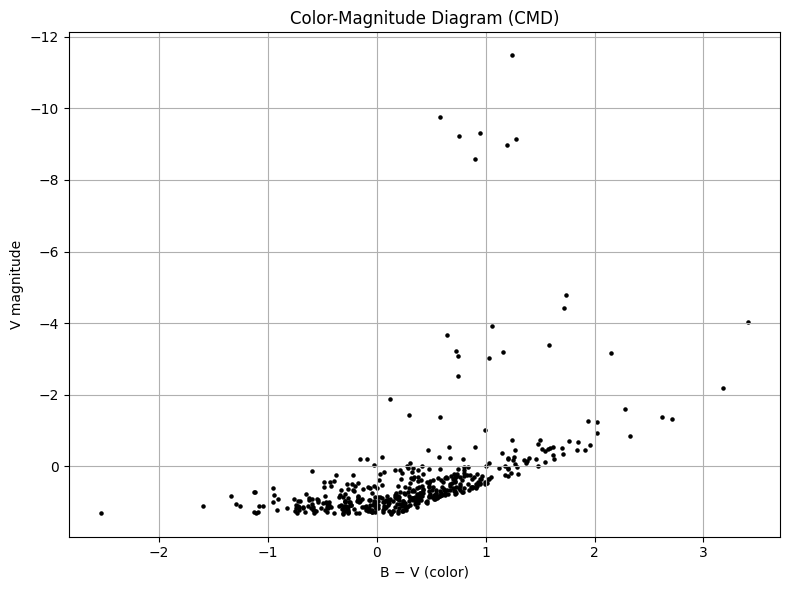

In [293]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(combined_catalog['B-V'], combined_catalog['mag_V'], s=5, color='black')
plt.gca().invert_yaxis()
plt.xlabel('B − V (color)')
plt.ylabel('V magnitude')
plt.title('Color-Magnitude Diagram (CMD)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [294]:
clean_catalog[['mag_B_corr', 'mag_V_corr', 'mag_R_corr', 'B-V', 'V-R']].head()


,mag_B_corr,mag_V_corr,mag_R_corr,B-V,V-R
0,-4.334485,-5.702518,-4.243088,1.368033,-1.459430
1,-4.328014,-5.139040,-4.882274,0.811027,-0.256766
2,-4.762958,-4.270243,-4.289629,-0.492715,0.019385
3,-4.755931,-5.837932,-4.689872,1.082001,-1.148060
4,-4.725556,-4.884364,-4.755211,0.158808,-0.129153


In [295]:
import pandas as pd
import gzip

isochrone_file = 'isoc_z019.dat.gz'

# Read gzipped isochrone file
with gzip.open(isochrone_file, 'rt') as f:
    lines = f.readlines()

# Extract only the rows containing actual data (skip headers)
data_lines = [line for line in lines if not line.startswith('#') and len(line.strip().split()) > 5]

# Convert to DataFrame
columns = ['Z', 'logAge', 'Mini', 'Mass', 'Teff', 'logL', 'logg', 'Mbol', 'UBmag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag']
iso_data = pd.DataFrame([list(map(float, line.strip().split())) for line in data_lines], columns=columns)


In [296]:
age_target = 9.0  # log(age/yr) = 9.0 → ~1 Gyr
iso_slice = iso_data[np.isclose(iso_data['logAge'], age_target, atol=0.01)]


In [297]:

distance_modulus = 14.5  # e.g. ~8 kpc
mag_V_shifted = clean_catalog['mag_V_corr'] + distance_modulus

# Correct isochrone mags
color_iso = (iso_slice['Bmag'] + A_B) - (iso_slice['Vmag'] + A_V)
mag_iso = iso_slice['Vmag'] + A_V + distance_modulus


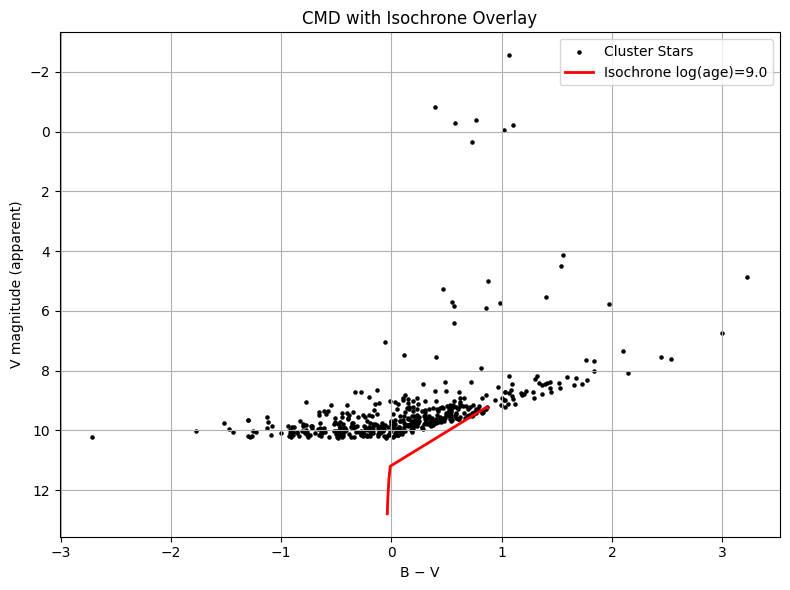

In [298]:
plt.figure(figsize=(8, 6))
plt.scatter(clean_catalog['B-V'], mag_V_shifted, s=5, color='black', label='Cluster Stars')
plt.plot(color_iso, mag_iso, color='red', lw=2, label=f'Isochrone log(age)={age_target}')
plt.gca().invert_yaxis()
plt.xlabel('B − V')
plt.ylabel('V magnitude (apparent)')
plt.title('CMD with Isochrone Overlay')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


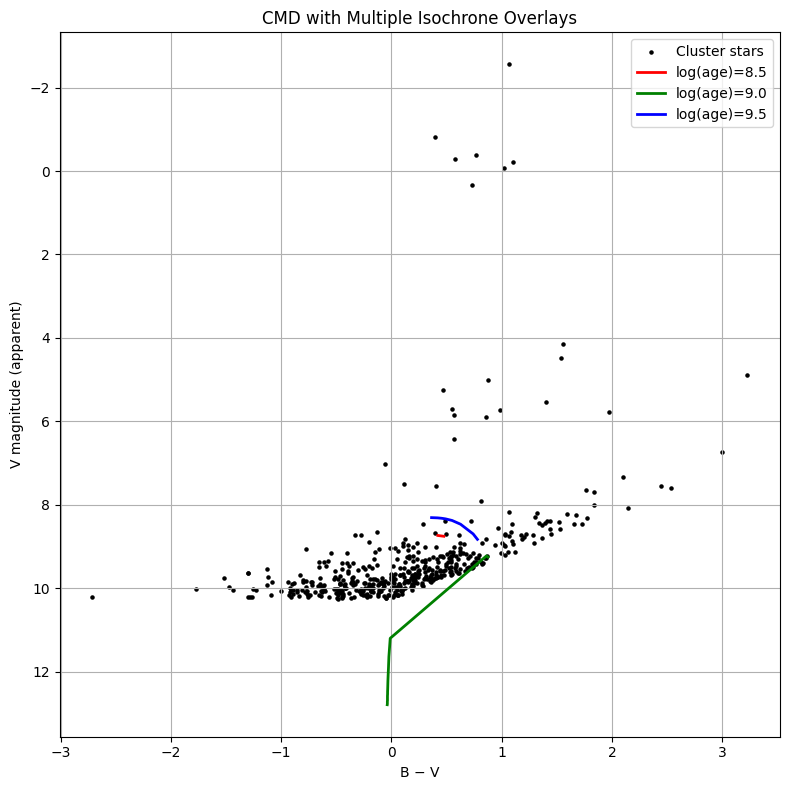

In [299]:
ages_to_plot = [8.5, 9.0, 9.5]  # log(age/yr)
colors = ['red', 'green', 'blue']

plt.figure(figsize=(8, 8))

# Plot CMD stars
plt.scatter(clean_catalog['B-V'], mag_V_shifted, s=5, color='black', label='Cluster stars')

# Overlay each isochrone
for age, color in zip(ages_to_plot, colors):
    iso_slice = iso_data[np.isclose(iso_data['logAge'], age, atol=0.01)]
    color_iso = (iso_slice['Bmag'] + A_B) - (iso_slice['Vmag'] + A_V)
    mag_iso = iso_slice['Vmag'] + A_V + distance_modulus
    plt.plot(color_iso, mag_iso, color=color, lw=2, label=f"log(age)={age}")

plt.gca().invert_yaxis()
plt.xlabel("B − V")
plt.ylabel("V magnitude (apparent)")
plt.title("CMD with Multiple Isochrone Overlays")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [300]:
# data = stacked_B.astype(np.float32)
# data = np.nan_to_num(data)
# bkg = sep.Background(data)
# data_sub = data - bkg.back()

# plt.imshow(data_sub, cmap='gray', origin='lower', vmin=np.percentile(data_sub, 5), vmax=np.percentile(data_sub, 99))
# plt.title("Background-subtracted stacked_B")
# plt.colorbar()
# plt.show()
